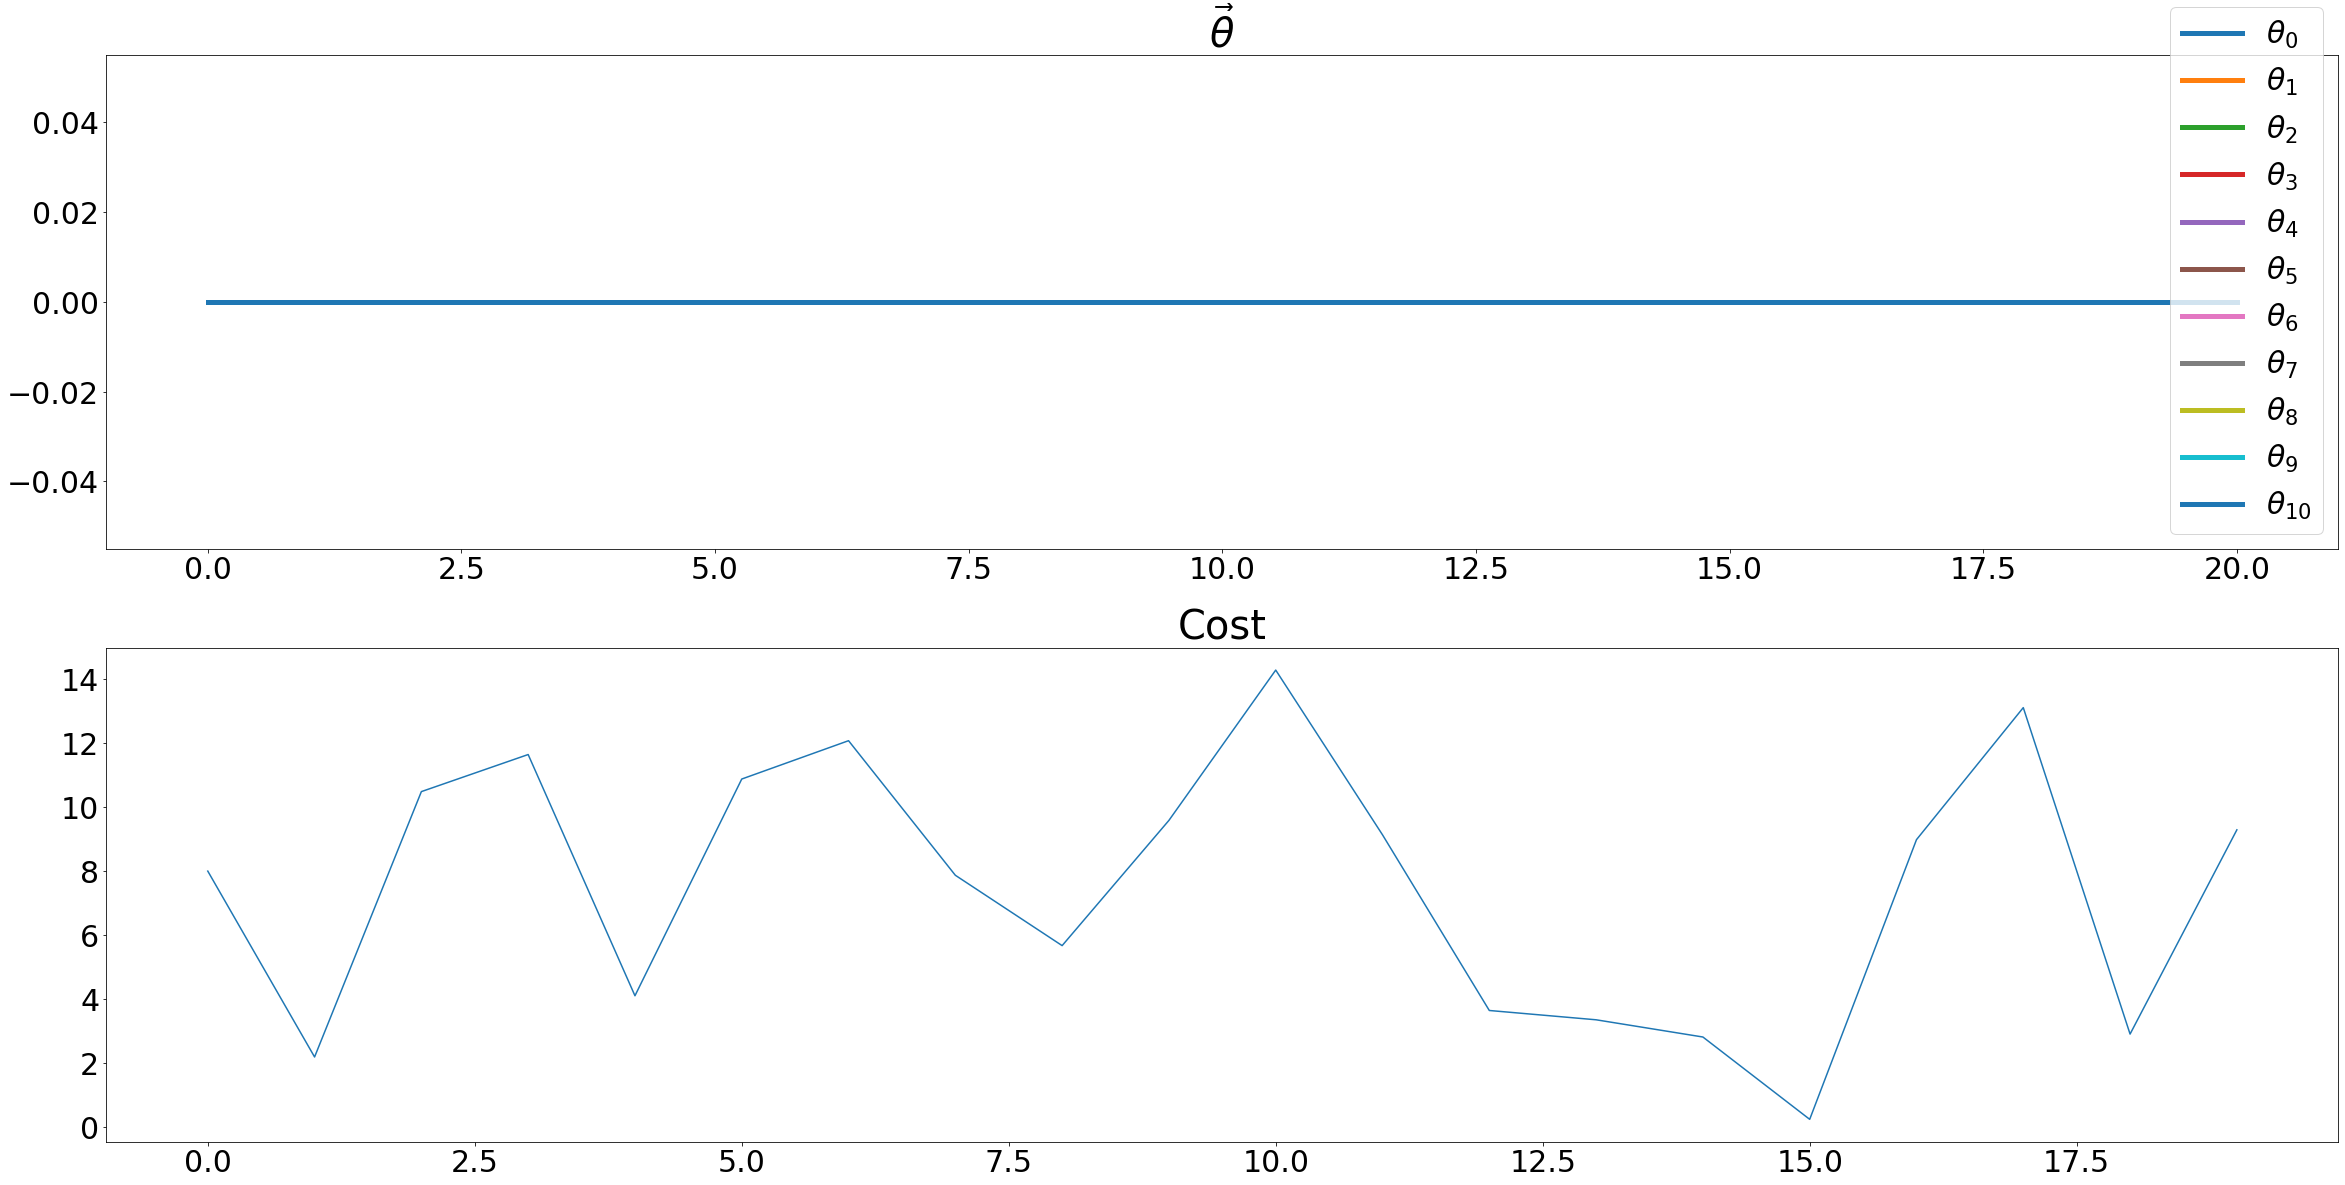

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class LR_dataset_generator:
    def __init__(self, feature_dim, n_sample = 100, noise = 0):
        self._feature_dim = feature_dim
        self._n_sample = n_sample
        self._noise = noise
        
        self._coefficient_list = None
        self._distribution_params = None
        
        self._dataset = None
        
        self._init_coefficient()
        self._init_distribution_params()
        
    def _init_coefficient(self):
        self._coefficient_list = [0] + [1 for _ in range(self._feature_dim)]
        
    def _init_distribution_params(self):
        self._distribution_params = {f:{'mean':0, 'std':1}
                                     for f in range(1, self._feature_dim+1)}
    
    def make_dataset(self):
        x_data = np.zeros(shape = (self._n_sample, 1))
        y_data = np.zeros(shape = (self._n_sample, 1))
        
        for f_idx in range(1, self._feature_dim + 1):
            feature_data = np.random.normal(loc = self._distribution_params[f_idx]['mean'],
                                            scale = self._distribution_params[f_idx]['std'],
                                            size = (self._n_sample, 1))
            x_data = np.hstack((x_data, feature_data))
            
            y_data += self._coefficient_list[f_idx]*feature_data
        y_data += self._coefficient_list[0]
        
        return x_data, y_data

    def set_n_sample(self, n_sample):
        self._n_sample = n_sample
    
    def set_noise(self, noise):
        self._noise = noise
    
    def set_distribution_params(self, distribution_params):
        for param_key, param_value in distribution_params.items():
            self._distribution_params[param_key] = param_value
    
    def set_coefficient(self, coefficient_list):
        self._coefficient_list = coefficient_list

#-------------------------------------------------------------------------

def get_data_batch(data, batch_idx):
    if batch_idx is n_batch - 1:
        batch = data[batch_idx*batch_size : ]
    else:
        batch = data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
    return batch

#--------------------------------------------------------------------------

class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x
    
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z
    
    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x) 
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx
    
#---------------------------------------------------------------------------

class Affine_Function:
    def __init__(self , feature_dim):
        self._feature_dim = feature_dim
        self._Th = Th
        
        self._Z1_list = [None]*(self._feature_dim + 1)
        self._Z2_list = self._Z1_list.copy() 
        self._dZ1_list, self._dZ2_list =  self._Z1_list.copy(), self._Z1_list.copy()
        self._dTh_list = self._Z1_list.copy()
        
        self.affine_imp()
        
    def affine_imp(self):
        self._node1 = [None] + [mul_node() for _ in range(self._feature_dim)]
        self._node2 = [None] + [plus_node() for _ in range(self._feature_dim)]
        
    def forward(self, X):
        for node_idx in range(1, self._feature_dim + 1):
            self._Z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx], X[:,node_idx])
            
        self._Z2_list[1] = self._node2[1].forward(self._Th[0], self._Z1_list[1])
        
        for node_idx in range(2, self._feature_dim + 1):
            self._Z2_list[node_idx] = self._node2[node_idx].forward(self._Z2_list[node_idx-1], self._Z1_list[node_idx])
            
        return self._Z2_list[-1]
    
    def backward(self, dZ2_last, lr):
        self._dZ2_list[-1] = dZ2_last

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dZ2, dZ1 = self._node2[node_idx].backward(self._dZ2_list[node_idx])
            self._dZ2_list[node_idx-1] = dZ2
            self._dZ1_list[node_idx] = dZ1
    
        self._dTh_list[0] = self._dZ2_list[0]

        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dTh, _ = self._node1[node_idx].backward(self._dZ1_list[node_idx])
            self._dTh_list[node_idx] = dTh
        
        for th_idx in range(self._Th.shape[0]):
            self._Th[th_idx] = self._Th[th_idx] - lr*np.sum(self._dTh_list[th_idx])
        
        return self._Th
        
#--------------------------------------------------------------------------------------------------------

class MSE_Cost:
    def __init__(self):
        self.cost_imp()
        
    def cost_imp(self):
        self._node3 = minus_node()
        self._node4 = square_node()
        self._node5 = mean_node()
        
    def forward(self, y, pred):
        Z3 = self._node3.forward(Y, Pred)
        Z4 = self._node4.forward(Z3)
        J = self._node5.forward(Z4)
        return J
    
    def backward(self):
        dZ4 = self._node5.backward(1)
        dZ3 = self._node4.backward(dZ4)
        _, dZ2_last = self._node3.backward(dZ3)
        return dZ2_last
    
#---------------------------------------------------------------------------------------

def result_visualization(th_accum, loss_list):
    fig, ax = plt.subplots(2,1, figsize = (40,20))
    for i in range(feature_dim + 1):
        ax[0].plot(th_accum[i], label = r'$\theta_{%d}$'%i, linewidth = 5)
            
    ax[1].plot(cost_list)
        
    ax[0].legend(loc = 'lower right', fontsize = 30)
    ax[0].tick_params(axis = 'both', labelsize = 30)
    ax[1].tick_params(axis = 'both', labelsize = 30)
        
    ax[0].set_title(r'$\vec{\theta}$', fontsize = 40)
    ax[1].set_title('Cost', fontsize = 40)
    
#-----------------------------------------------------------------------------------------

feature_dim = 10
batch_size = 8

data_gen = LR_dataset_generator(feature_dim = feature_dim)
x_data, y_data = data_gen.make_dataset()
data = np.hstack((x_data, y_data))
n_batch = np.ceil(data.shape[0]/batch_size).astype(int)

Th = np.array([1,2,3,4,5,6,7,8,9,10,11]).reshape(-1,1)
epochs, lr = 20, 0.001

th_accum = Th.reshape(-1,1)
cost_list = []

affine = Affine_Function(feature_dim)
cost = MSE_Cost()

for epoch in range(epochs):
    np.random.shuffle(data)
    
    for batch_idx in range(n_batch):
        batch = get_data_batch(data, batch_idx)
        X, Y = batch[:,:-1], batch[:,-1]
        
        Pred = affine.forward(X)
        J = cost.forward(Y, Pred)
        
        dPred = cost.backward()
        affine.backward(dPred, lr)
        
    th_accum = np.hstack((th_accum, affine._Th))
    cost_list.append(J)
    
result_visualization(th_accum, cost_list)